<a href="https://colab.research.google.com/github/Ayan2109/CIFAR10_image_classification/blob/main/CIFAR10_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing important libraries

In [1]:
import cv2
import torch
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
composed = transform.Compose([
    transform.ToTensor(),
    transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

Loading the data

In [4]:
batch_size = 4
trainset = datasets.CIFAR10(root ='./data', train = True, download = True, transform=composed)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle = True)

testset =  datasets.CIFAR10(root = './data', train = False, download = True, transform=composed)
testloader = DataLoader(testset, batch_size=batch_size, shuffle = False)

classes = ['airplane','car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship','truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


First 4 images

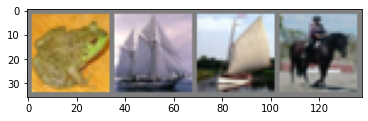

frog  ship  ship  horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

###Creating the CNN model

In [8]:
torch.manual_seed(0)
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 16, kernel_size = 5)
        self.bn_conv1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 3, stride= 2)
        self.conv2 = nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 5)
        self.bn_conv2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.fc1= nn.Linear(32*4*4, 120)
        self.drop = nn.Dropout(0.50)
        self.fc2 = nn.Linear(120,10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = torch.relu(x)   
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn_conv2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [9]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn_conv1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn_conv2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

Declaring hyperparameters 

In [10]:
n_epochs = 10
loss_list_train = []
accuracy_list_train = []
loss_list_test = []
accuracy_list_test = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

###Training the Model

In [11]:
for epoch in range(n_epochs):
    model.train()
    epoch_acc = 0
    epoch_loss = 0
    for x,y in trainloader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z,y)
        loss.backward()
        optimizer.step()
        acc = ((z.argmax(dim=1) == y).float().mean())
        epoch_acc += acc/len(trainloader) 
        epoch_loss += loss/len(trainloader)
    accuracy_list_train.append(torch.IntTensor.item(epoch_acc))
    loss_list_train.append(torch.IntTensor.item(epoch_loss))
    print('Epoch : {}, Epoch Accuracy : {:.3f}, Epoch Loss : {:.3f}'.format(epoch+1, epoch_acc, epoch_loss))

Epoch : 1, Epoch Accuracy : 0.336, Epoch Loss : 1.805
Epoch : 2, Epoch Accuracy : 0.421, Epoch Loss : 1.599
Epoch : 3, Epoch Accuracy : 0.465, Epoch Loss : 1.491
Epoch : 4, Epoch Accuracy : 0.499, Epoch Loss : 1.421
Epoch : 5, Epoch Accuracy : 0.524, Epoch Loss : 1.364
Epoch : 6, Epoch Accuracy : 0.538, Epoch Loss : 1.330
Epoch : 7, Epoch Accuracy : 0.547, Epoch Loss : 1.301
Epoch : 8, Epoch Accuracy : 0.558, Epoch Loss : 1.274
Epoch : 9, Epoch Accuracy : 0.567, Epoch Loss : 1.251
Epoch : 10, Epoch Accuracy : 0.573, Epoch Loss : 1.236


###Graph between number of epochs and loss & number of epochs and accuracy

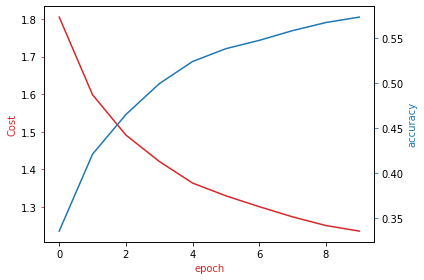

In [12]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list_train, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list_train, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

As we can see from the above graph as the number of epoch increases the training accuracy of the model increases and loss decreases

###Testing the model on test data

In [13]:
# test
total = 0
correct = 0
model.eval()
with torch.no_grad():
    for x,y in testloader:
        z = model(x)
        _, yhat = torch.max(z,1)
        total += y.size(0)
        correct += (yhat==y).sum().item()

print('Accuracy of the model on Test data: {}%'.format(100*correct//total))


Accuracy of the model on Test data: 65%


*Model has an accuracy of 65% on testing data*

###Predicted value for first batch in testing data along with the true value

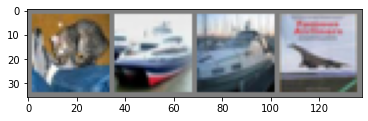

True Value:  cat   ship  ship  airplane


In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('True Value: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [20]:
predict = model(images)
_, yhat = torch.max(predict,1)

print('Predicted: ', ' '.join(f'{classes[yhat[j]]:5s}' for j in range(4)))

Predicted:  ship  ship  ship  airplane
